In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install --quiet lightning
! pip install --quiet transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 33.0 MB/s eta 0:00:00


In [3]:
! pip install --quiet accelerate -U
! pip install --quiet transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 6.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import re
import string
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [5]:
import transformers

In [6]:
test_path = '/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/Data/new_essay_val_preprocessed.csv'
deploytest_path = '/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/Data/test_data_preprocessed.csv'

df_test = pd.read_csv(test_path)
df_deploy = pd.read_csv(deploytest_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## datasets preparation

In [7]:
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        record = self.dataframe.iloc[idx]
        text = record['text']
        label = record['label']

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [8]:
class TextMetaDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

        meta_features = dataframe[['sentence_variation', '%stop_word_total', 'mean_word_length', '%adjectives_total']]
        self.scaler = StandardScaler()
        self.scaler.fit(meta_features)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        record = self.dataframe.iloc[idx]
        text = record['text']
        label = record['label']
        metafeatures = [
            record['sentence_variation'],
            record['%stop_word_total'],
            record['mean_word_length'],
            record['%adjectives_total']
        ]

        metafeatures = self.scaler.transform([metafeatures])[0]

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Extract input_ids and attention_mask
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        metafeatures = torch.tensor(metafeatures, dtype=torch.float)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'meta_features': metafeatures,
            'label': torch.tensor(label, dtype=torch.long)
        }

## model utility

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_recall_curve, roc_curve, auc, roc_auc_score,
                             precision_score, recall_score, f1_score, accuracy_score,
                             confusion_matrix, ConfusionMatrixDisplay)

class ModelUtility:
    def __init__(self, model, device, acceptable_recall=0.70, precision_weight=0.3):
        self.model = model
        self.device = device
        self.acceptable_recall = acceptable_recall
        self.precision_weight = precision_weight

    def model_predict(self, test_loader, return_labels=False):
        self.model.eval()  # Set the model to evaluation mode
        true_labels = []
        predicted_probs = []
        predicted_labels = []

        with torch.no_grad():
            for batch in test_loader:
                inputs = {
                    'input_ids': batch['input_ids'].to(self.device),
                    'attention_mask': batch['attention_mask'].to(self.device)
                }

                if 'meta_features' in batch:
                    inputs['meta_features'] = batch['meta_features'].to(self.device)

                if return_labels:
                    labels = batch['label'].to(self.device)

                outputs = self.model(**inputs)
                logits = outputs if isinstance(outputs, torch.Tensor) else outputs.logits

                probs = torch.softmax(logits, dim=1)
                pos_probs = probs[:, 1]
                preds = torch.argmax(probs, dim=1)

                predicted_probs.extend(pos_probs.cpu().numpy())
                predicted_labels.extend(preds.cpu().numpy())
                if return_labels:
                    true_labels.extend(labels.cpu().numpy())

        return (predicted_probs, predicted_labels, true_labels) if return_labels else (predicted_probs, predicted_labels)

    def threshold_precision(self, true_labels, probabilities):
        precision, recall, thresholds = precision_recall_curve(true_labels, probabilities)
        auprc = auc(recall, precision)
        print(f"AUPRC: {auprc:.4f}")

        auroc = roc_auc_score(true_labels, probabilities)
        print(f"AUROC: {auroc:.4f}")

        acceptable_indices = np.where(recall >= self.acceptable_recall)[0]
        if len(acceptable_indices) > 0:
            optimal_idx = acceptable_indices[np.argmax(precision[acceptable_indices])]
            optimal_threshold = thresholds[optimal_idx]
            print(f"Optimal Threshold: {optimal_threshold:.4f}")
            return optimal_threshold
        else:
            print("No threshold found with the recall above or equal to the acceptable level.")
            return None

    def threshold_recall(self, true_labels, probabilities):
        precision, recall, thresholds = precision_recall_curve(true_labels, probabilities)
        auprc = auc(recall, precision)
        print(f"AUPRC: {auprc:.4f}")

        auroc = roc_auc_score(true_labels, probabilities)
        print(f"AUROC: {auroc:.4f}")

        # Calculate the F-score with the given precision weight
        if self.precision_weight < 1:
            beta = np.sqrt((1 - self.precision_weight) / self.precision_weight)
            fscore = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
        else:
            fscore = 2 * (precision * recall) / (precision + recall)  # When weight is 1, it's the regular F1 score

        fscore[np.isnan(fscore)] = 0  # Handle the case where precision and recall are both zero

        acceptable_indices = np.where(recall >= self.acceptable_recall)[0]
        if len(acceptable_indices) > 0:
            optimal_idx = acceptable_indices[np.argmax(fscore[acceptable_indices])]
            optimal_threshold = thresholds[optimal_idx]
            print(f"Optimal Threshold: {optimal_threshold:.4f} with F-score: {fscore[optimal_idx]:.4f}")
            return optimal_threshold
        else:
            print("No threshold found with the recall above or equal to the acceptable level.")
            return None

    def model_test(self, true_labels, probabilities, threshold=0.50):
        probabilities = np.array(probabilities)

        precision, recall, thresholds_prc = precision_recall_curve(true_labels, probabilities)
        auprc = auc(recall, precision)
        print(f"AUPRC: {auprc:.4f}")

        fpr, tpr, thresholds_roc = roc_curve(true_labels, probabilities)
        auroc = roc_auc_score(true_labels, probabilities)
        print(f"AUROC: {auroc:.4f}")

        predictions = (probabilities >= threshold).astype(int)

        precision_score_val = precision_score(true_labels, predictions)
        recall_score_val = recall_score(true_labels, predictions)
        f1_score_val = f1_score(true_labels, predictions)
        accuracy_score_val = accuracy_score(true_labels, predictions)

        print(f"Threshold: {threshold:.4f}")
        print(f"Precision: {precision_score_val:.4f}")
        print(f"Recall: {recall_score_val:.4f}")
        print(f"F1 Score: {f1_score_val:.4f}")
        print(f"Accuracy: {accuracy_score_val:.4f}")

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

        # Precision-Recall Curve
        ax1.plot(recall, precision, label=f'PR Curve (area = {auprc:.2f})')
        ax1.set_xlabel('Recall')
        ax1.set_ylabel('Precision')
        ax1.set_title('Precision-Recall Curve')
        ax1.legend(loc="best")
        ax1.grid(True)

        # ROC Curve
        ax2.plot(fpr, tpr, label=f'ROC Curve (area = {auroc:.2f})')
        ax2.plot([0, 1], [0, 1], 'r--')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('ROC Curve')
        ax2.legend(loc="best")
        ax2.grid(True)

        # Confusion Matrix
        cm = confusion_matrix(true_labels, predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap=plt.cm.Blues, ax=ax3)
        ax3.set_title('Confusion Matrix')
        ax3.set_xlabel('Predicted Labels')
        ax3.set_ylabel('True Labels')

        plt.tight_layout()
        plt.show()


# GPT2

In [101]:
tokenizer = transformers.GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer)

In [102]:
finetuneset = pd.read_csv('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/Data/new_essay_train_preprocessed.csv')
df_train, df_val = train_test_split(finetuneset, test_size=0.2, random_state = 33)

train_dataset = TextDataset(df_train, tokenizer)
val_dataset = TextDataset(df_val, tokenizer)

train_loader = DataLoader(dataset=train_dataset, batch_size=6)
val_loader = DataLoader(dataset=val_dataset, batch_size=6)

In [103]:
model = torch.load('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/GPT2/GPT2-kagglewiki-nometa.pth')
model.to(device)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [104]:
training_args = transformers.TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=15,             # number of training epochs
    per_device_train_batch_size=6,   # batch size for training
    per_device_eval_batch_size=6,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=50,
    evaluation_strategy="epoch"
)


trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.000193
2,No log,0.000193
3,No log,0.001882
4,No log,0.650315
5,No log,1.151166
6,No log,1.068589
7,0.410200,0.927516
8,0.410200,1.047019
9,0.410200,1.295282
10,0.410200,1.932504


TrainOutput(global_step=120, training_loss=0.18441424598568118, metrics={'train_runtime': 89.1209, 'train_samples_per_second': 8.079, 'train_steps_per_second': 1.346, 'total_flos': 188133660426240.0, 'train_loss': 0.18441424598568118, 'epoch': 15.0})

In [105]:
torch.save(model, '/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/GPT2/GPT2-kagglewiki-nometa-finetune.pth')

In [106]:
test_dataset = TextDataset(df_test, tokenizer)
deploy_dataset = TextDataset(df_deploy, tokenizer)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)
deploy_loader = DataLoader(dataset=deploy_dataset, batch_size=1)

In [107]:
model_utility = ModelUtility(model, device)

AUPRC: 0.9933
AUROC: 0.9925
Threshold: 0.5000
Precision: 0.9500
Recall: 0.9500
F1 Score: 0.9500
Accuracy: 0.9500


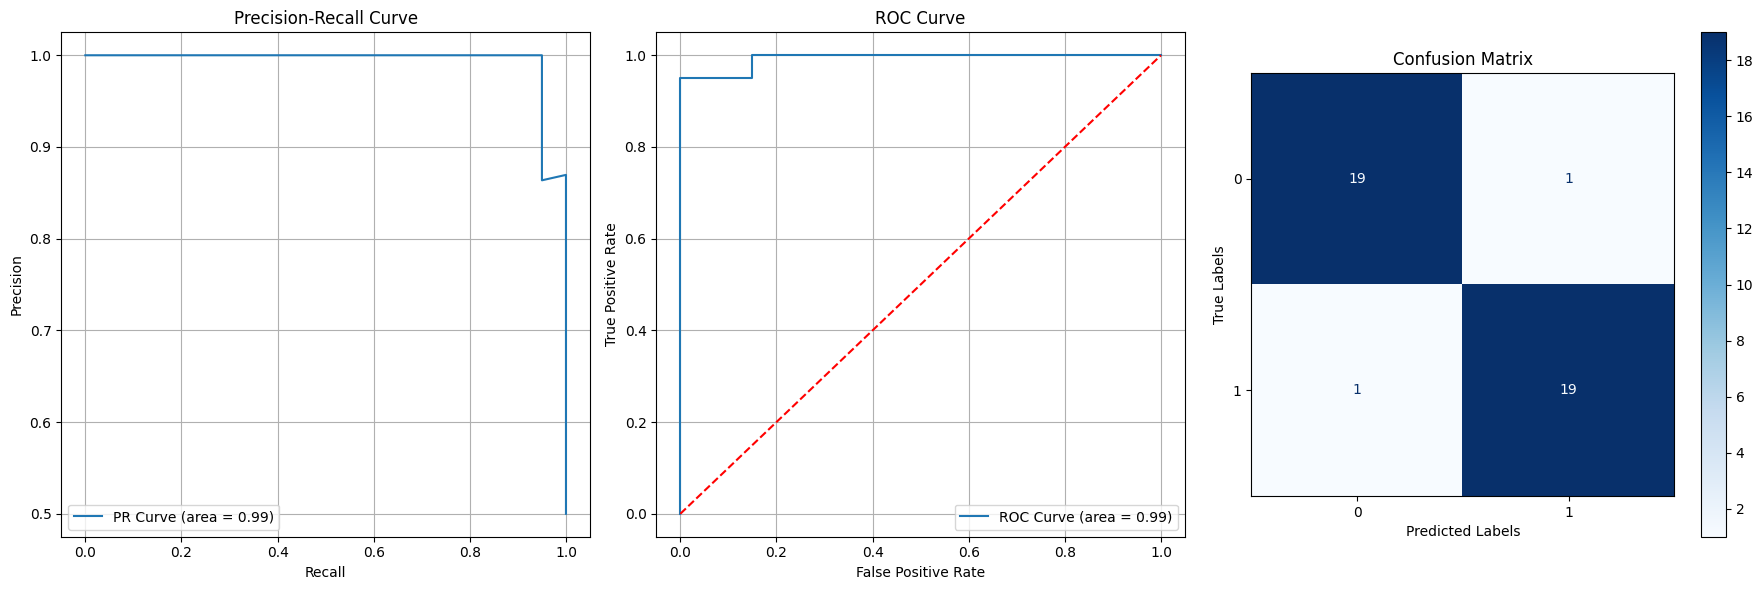

In [108]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(test_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

AUPRC: 0.9715
AUROC: 0.9664
Threshold: 0.5000
Precision: 1.0000
Recall: 0.5600
F1 Score: 0.7179
Accuracy: 0.7800


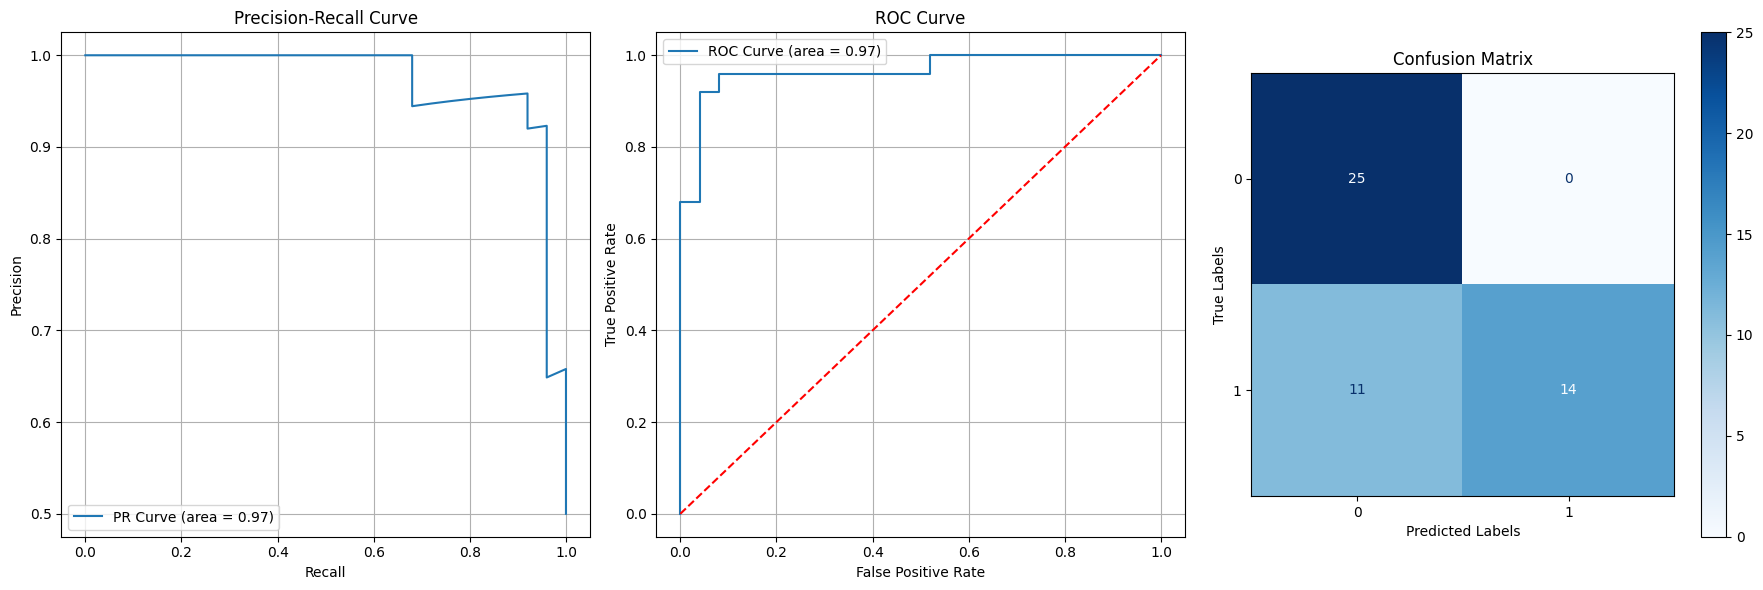

In [109]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(deploy_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

In [38]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(val_loader, return_labels=True)
threshold = model_utility.threshold_recall(true_labels, predicted_probs)

AUPRC: 1.0000
AUROC: 1.0000
Optimal Threshold: 1.0000 with F-score: 1.0000


AUPRC: 1.0000
AUROC: 1.0000
Threshold: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Accuracy: 1.0000


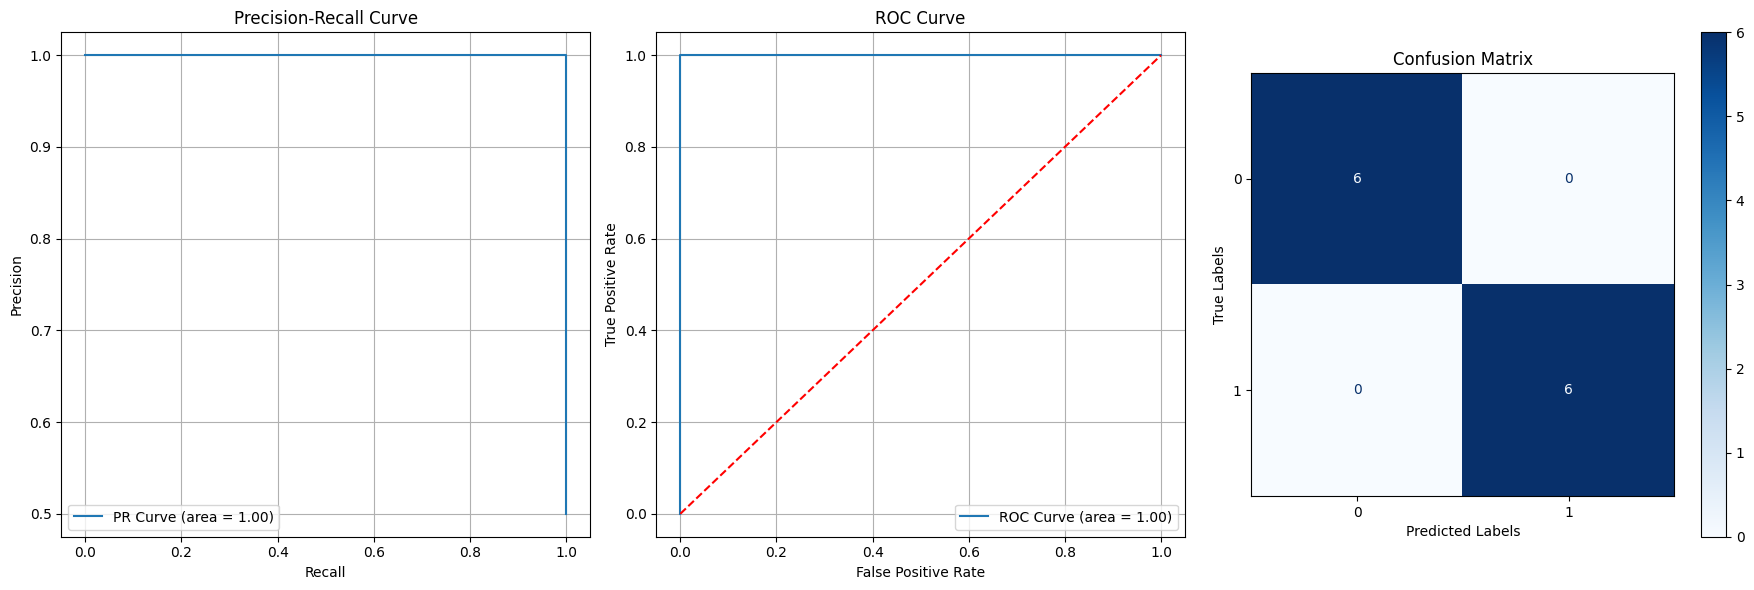

In [41]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(val_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs, threshold)

AUPRC: 0.9933
AUROC: 0.9925
Threshold: 1.0000
Precision: 1.0000
Recall: 0.6000
F1 Score: 0.7500
Accuracy: 0.8000


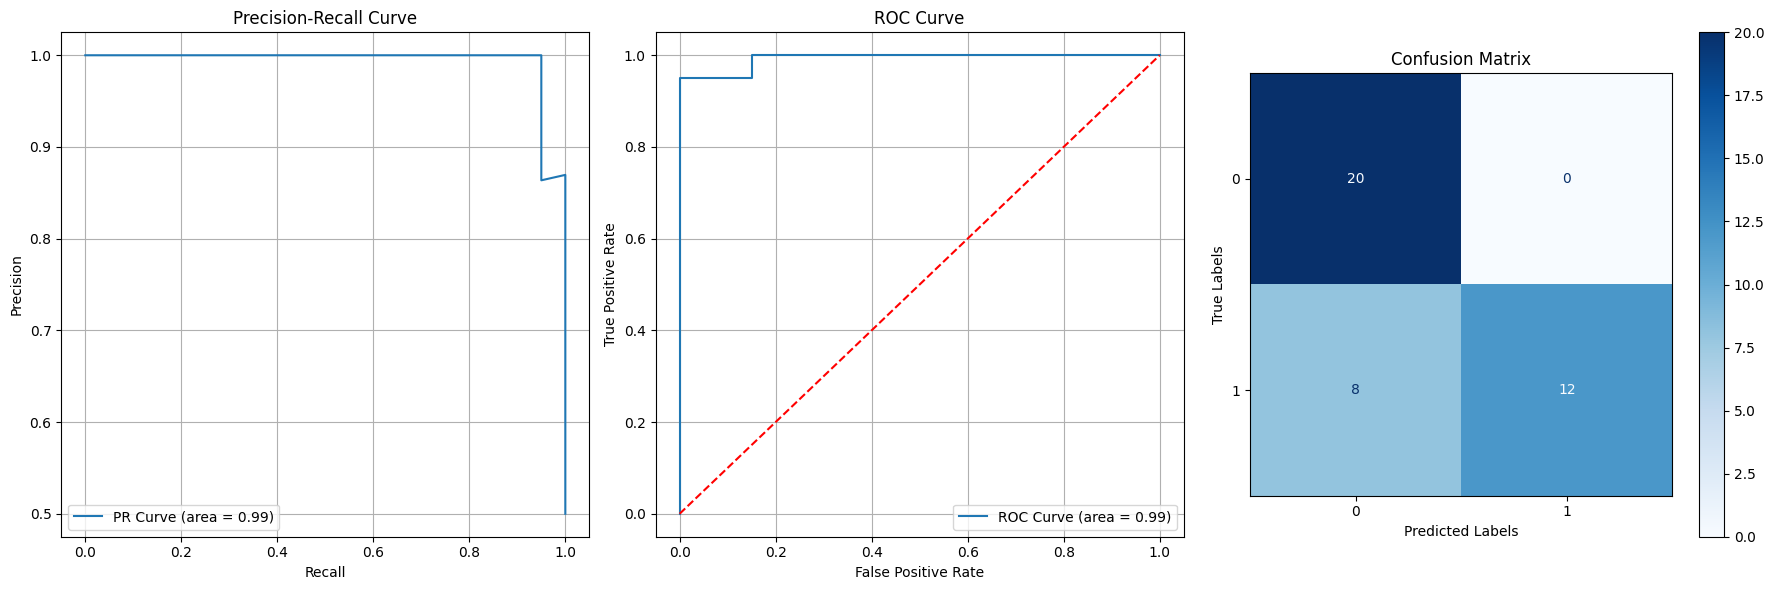

In [42]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(test_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs, threshold)

AUPRC: 0.9715
AUROC: 0.9664
Threshold: 1.0000
Precision: 1.0000
Recall: 0.0800
F1 Score: 0.1481
Accuracy: 0.5400


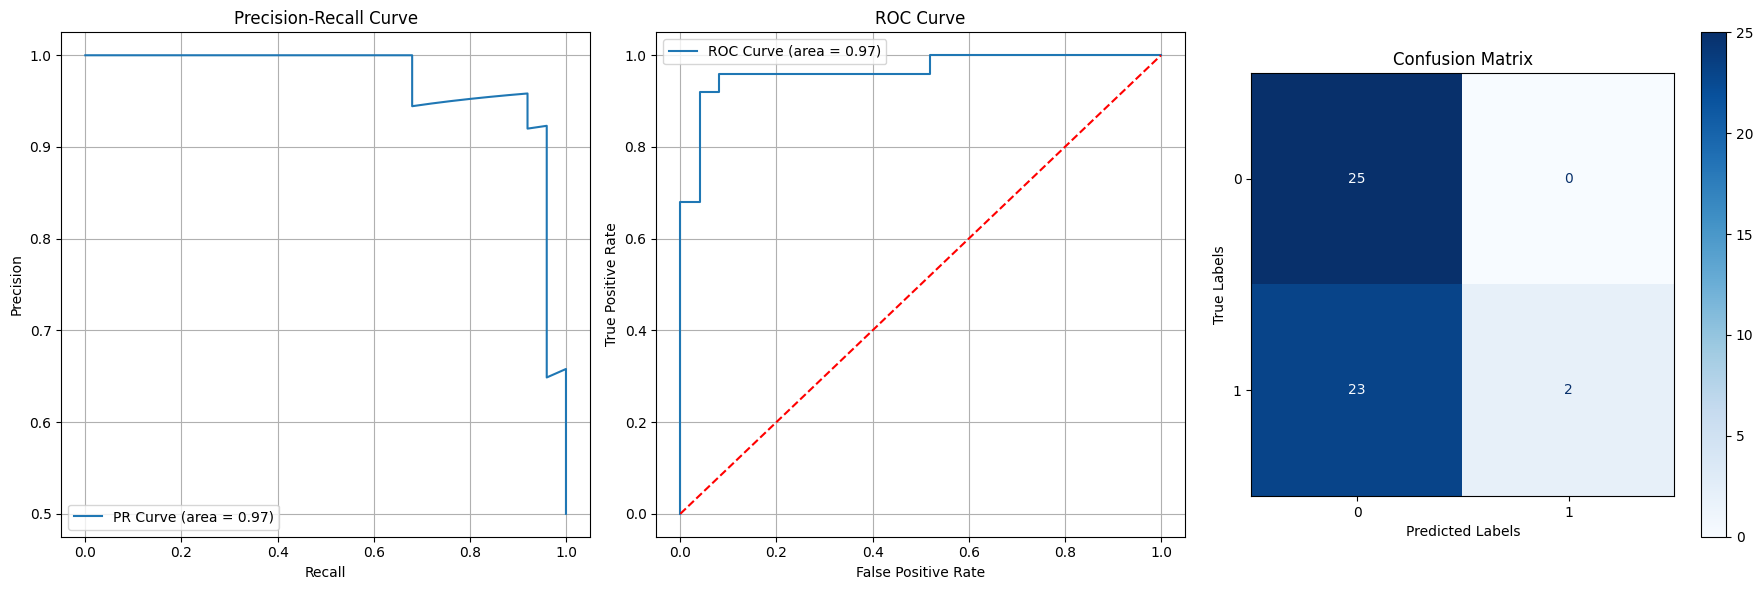

In [43]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(deploy_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs, threshold)

# XLnet

In [44]:
class XLNetMetaLightningModule(pl.LightningModule):
    def __init__(self, model_name, config, num_labels=2):
        super().__init__()
        # Initialize the XLNet model for sequence classification
        self.xlnet = transformers.XLNetForSequenceClassification.from_pretrained(model_name, config=config)

        self.meta_feature_processor = nn.Sequential(
            nn.Linear(4, 16),  # 4 metafeatures
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU()
        )
        # Classifier that uses combined XLNet features and metafeatures
        combined_features_dim = self.xlnet.config.hidden_size + 16  # Assuming the hidden size from XLNet and meta features
        self.classifier = nn.Linear(combined_features_dim, num_labels)

    def forward(self, input_ids, attention_mask, meta_features):
        outputs = self.xlnet(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.hidden_states[-1]
        xlnet_features = last_hidden_state[:, 0, :]   # Get the features from the CLS token

        meta_features = self.meta_feature_processor(meta_features)

        combined_features = torch.cat((xlnet_features, meta_features), dim=1)

        logits = self.classifier(combined_features)
        return logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        meta_features = batch['meta_features']
        labels = batch['label']
        logits = self(input_ids, attention_mask, meta_features)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:, 1]
        self.log('train_loss', loss, on_step=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        meta_features = batch['meta_features']
        labels = batch['label']
        logits = self(input_ids, attention_mask, meta_features)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:, 1]
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=5e-5)
        return optimizer

In [45]:
tokenizer = transformers.XLNetTokenizer.from_pretrained('xlnet-base-cased')
config = transformers.XLNetConfig.from_pretrained('xlnet-base-cased', num_labels=2, output_hidden_states=True)
model = XLNetMetaLightningModule('xlnet-base-cased', config)

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
finetuneset = pd.read_csv('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/Data/new_essay_train_preprocessed.csv')
df_train, df_val = train_test_split(finetuneset, test_size=0.2, random_state = 33)

train_dataset = TextMetaDataset(df_train, tokenizer)
val_dataset = TextMetaDataset(df_val, tokenizer)

train_loader = DataLoader(dataset=train_dataset, batch_size=6)
val_loader = DataLoader(dataset=val_dataset, batch_size=6)

In [48]:
state_dict = torch.load('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/XLnet/XLnet_kagglewiki_withmeta_checkpoint.pth')
model.load_state_dict(state_dict)
model.to(device)

XLNetMetaLightningModule(
  (xlnet): XLNetForSequenceClassification(
    (transformer): XLNetModel(
      (word_embedding): Embedding(32000, 768)
      (layer): ModuleList(
        (0-11): 12 x XLNetLayer(
          (rel_attn): XLNetRelativeAttention(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (ff): XLNetFeedForward(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (layer_1): Linear(in_features=768, out_features=3072, bias=True)
            (layer_2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (activation_function): GELUActivation()
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (sequence_summary): SequenceSummary(
      (summary): Linear(in_features=768, out_features=7

In [51]:
callbacks = [
    ModelCheckpoint(
        save_top_k=1,
        mode="min",
        monitor="val_loss"
    )  # save top 1 model
]

# Trainer configuration
trainer = pl.Trainer(
    max_epochs=15,
    callbacks=callbacks,
    devices=1,
    logger=False
)

trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                   | Type                           | Params
--------------------------------------------------------------------------
0 | xlnet                  | XLNetForSequenceClassification | 117 M 
1 | meta_feature_processor | Sequential                     | 352   
2 | classifier             | Linear                         | 1.6 K 
--------------------------------------------------------------------------
117 M     Trainable params
0         Non-trainable params
117 M     Total params
469.250   Total estimated model params

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


In [52]:
torch.save(model, '/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/XLnet/XLnet_kagglewiki_withmeta-finetuned.pth')

In [53]:
test_dataset = TextMetaDataset(df_test, tokenizer)
deploy_dataset = TextMetaDataset(df_deploy, tokenizer)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)
deploy_loader = DataLoader(dataset=deploy_dataset, batch_size=1)

In [56]:
model.to(device)
model_utility = ModelUtility(model, device)

AUPRC: 0.9953
AUROC: 0.9950
Threshold: 0.5000
Precision: 1.0000
Recall: 0.9500
F1 Score: 0.9744
Accuracy: 0.9750


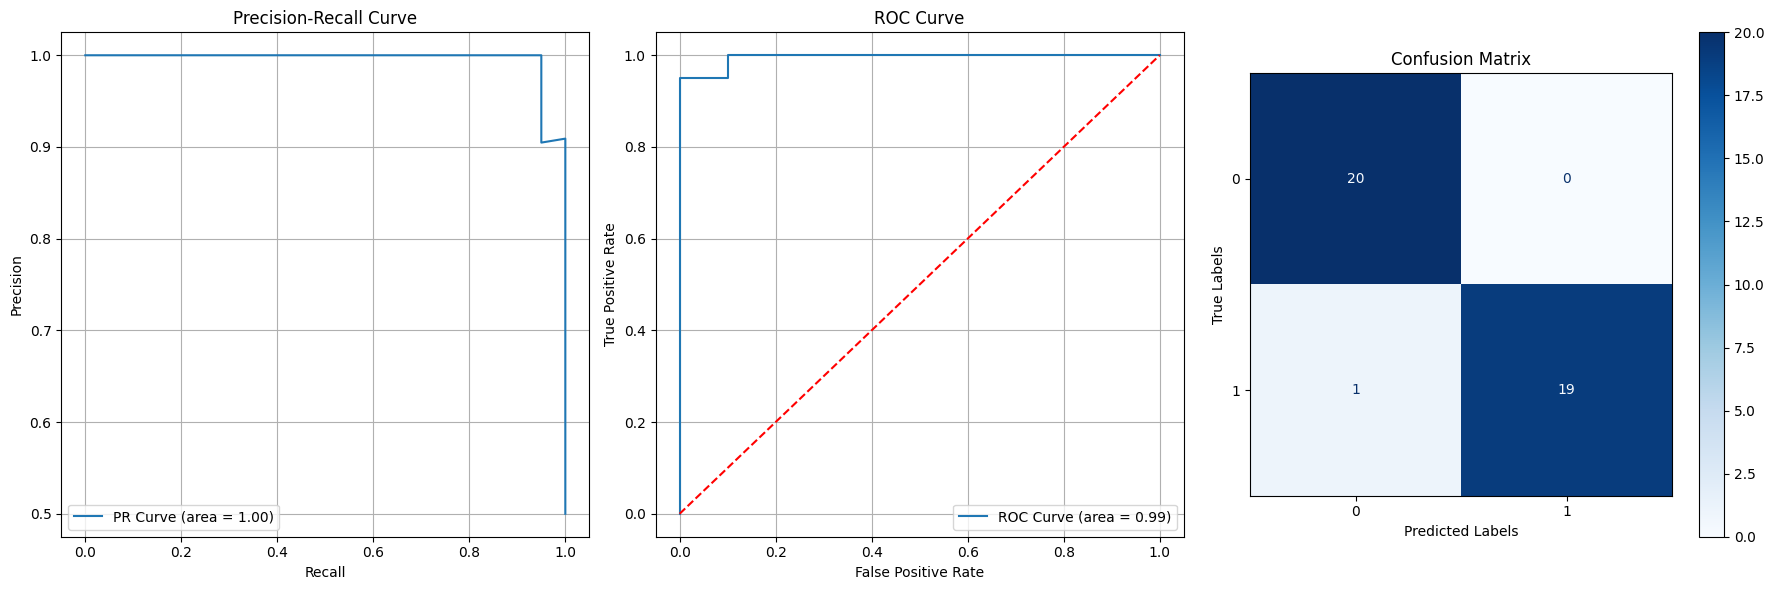

In [57]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(test_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

AUPRC: 0.9620
AUROC: 0.9600
Threshold: 0.5000
Precision: 1.0000
Recall: 0.5200
F1 Score: 0.6842
Accuracy: 0.7600


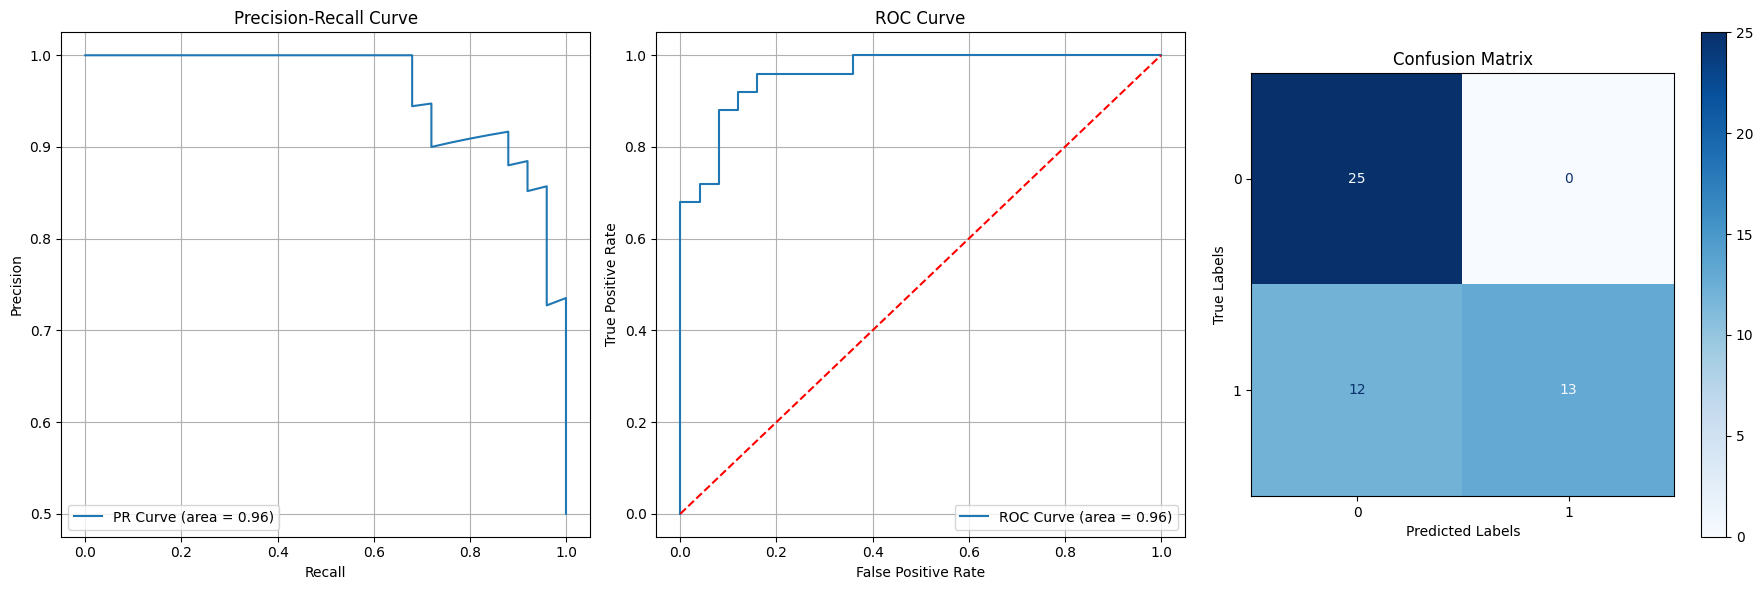

In [58]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(deploy_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

# DistilBert

In [59]:
class LightningModule(pl.LightningModule):
    def __init__(self, model_name, config, num_labels=2):
        super().__init__()
        self.model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

        self.meta_feature_processor = nn.Sequential(
            nn.Linear(4, 16),  # 4 metafeatures
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU()
        )

        combined_features_dim = self.model.config.hidden_size + 16
        self.classifier = nn.Linear(combined_features_dim, num_labels)

    def forward(self, input_ids, attention_mask, meta_features):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.hidden_states[-1]
        sequence_features = last_hidden_state[:, 0, :]

        meta_features = self.meta_feature_processor(meta_features)

        combined_features = torch.cat((sequence_features, meta_features), dim=1)

        logits = self.classifier(combined_features)
        return logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        meta_features = batch['meta_features']
        labels = batch['label']
        logits = self(input_ids, attention_mask, meta_features)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:, 1]
        self.log('train_loss', loss, on_step=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        meta_features = batch['meta_features']
        labels = batch['label']
        logits = self(input_ids, attention_mask, meta_features)
        loss = F.cross_entropy(logits, labels)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:, 1]
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=2e-5)
        return optimizer

In [60]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
config = transformers.DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=2, output_hidden_states=True)
model = LightningModule('distilbert-base-uncased', config)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
finetuneset = pd.read_csv('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/Data/new_essay_train_preprocessed.csv')
df_train, df_val = train_test_split(finetuneset, test_size=0.2, random_state = 33)

train_dataset = TextMetaDataset(df_train, tokenizer)
val_dataset = TextMetaDataset(df_val, tokenizer)

train_loader = DataLoader(dataset=train_dataset, batch_size=6)
val_loader = DataLoader(dataset=val_dataset, batch_size=6)

In [62]:
model = torch.load('/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/DistilBert/DistilBert_kagglewiki_withmeta.pth')
model.to(device)

LightningModule(
  (model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            

In [63]:
callbacks = [
    ModelCheckpoint(
        save_top_k=1,
        mode="min",
        monitor="val_loss"
    )  # save top 1 model
]

# Trainer configuration
trainer = pl.Trainer(
    max_epochs=15,
    callbacks=callbacks,
    devices=1,
    logger=False
)

trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                   | Type                                | Params
-------------------------------------------------------------------------------
0 | model                  | DistilBertForSequenceClassification | 67.0 M
1 | meta_feature_processor | Sequential                          | 352   
2 | classifier             | Linear                              | 1.6 K 
-------------------------------------------------------------------------------
67.0 M    Trainable params
0         Non-trainable params
67.0 M    Total params
267.828 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


In [64]:
torch.save(model, '/content/drive/MyDrive/NUS_MSBA/BT5153_Final Group Project_Shared Folder/models/DistilBert/DistilBert_kagglewiki_withmeta-finetuned.pth')

In [65]:
test_dataset = TextMetaDataset(df_test, tokenizer)
deploy_dataset = TextMetaDataset(df_deploy, tokenizer)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)
deploy_loader = DataLoader(dataset=deploy_dataset, batch_size=1)

In [66]:
model.to(device)
model_utility = ModelUtility(model, device)

AUPRC: 1.0000
AUROC: 1.0000
Threshold: 0.5000
Precision: 1.0000
Recall: 0.9000
F1 Score: 0.9474
Accuracy: 0.9500


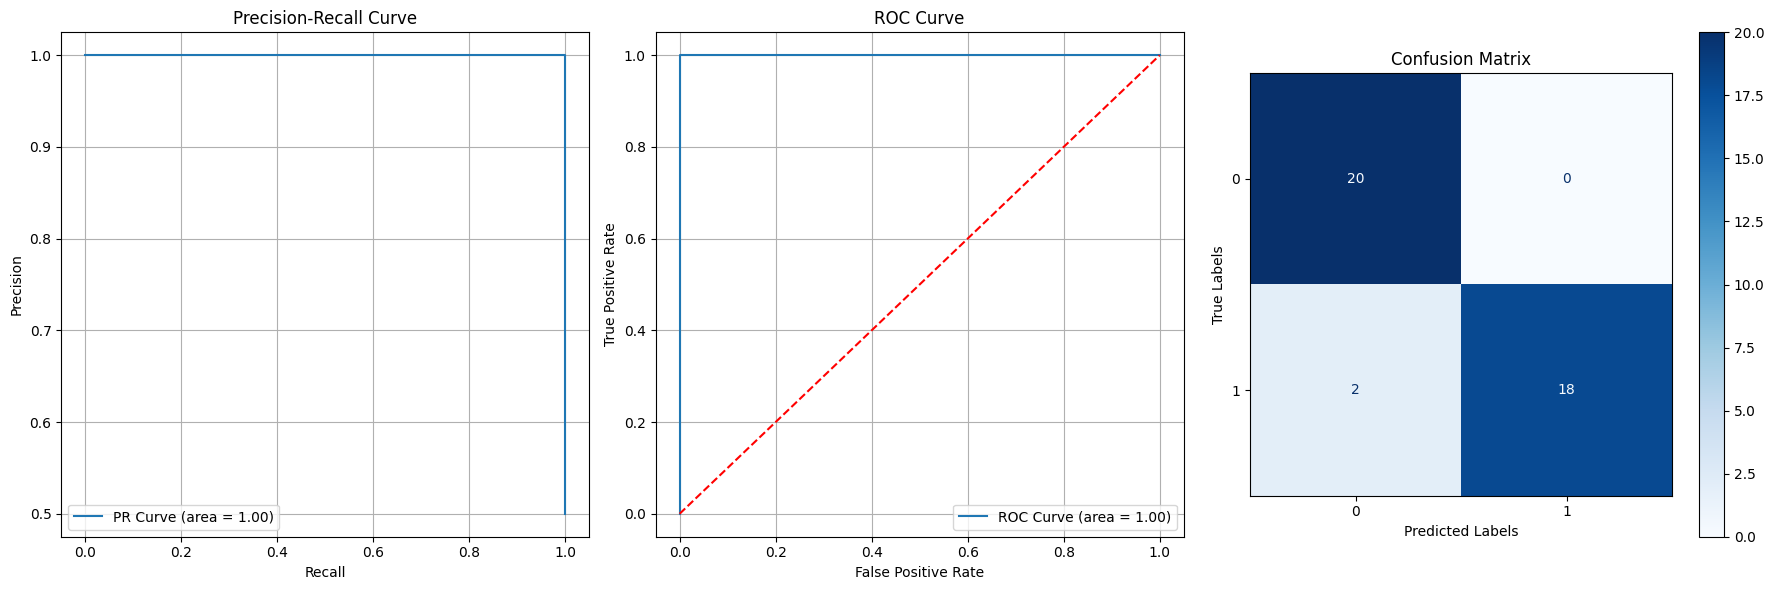

In [67]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(test_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)

AUPRC: 0.9641
AUROC: 0.9648
Threshold: 0.5000
Precision: 1.0000
Recall: 0.2400
F1 Score: 0.3871
Accuracy: 0.6200


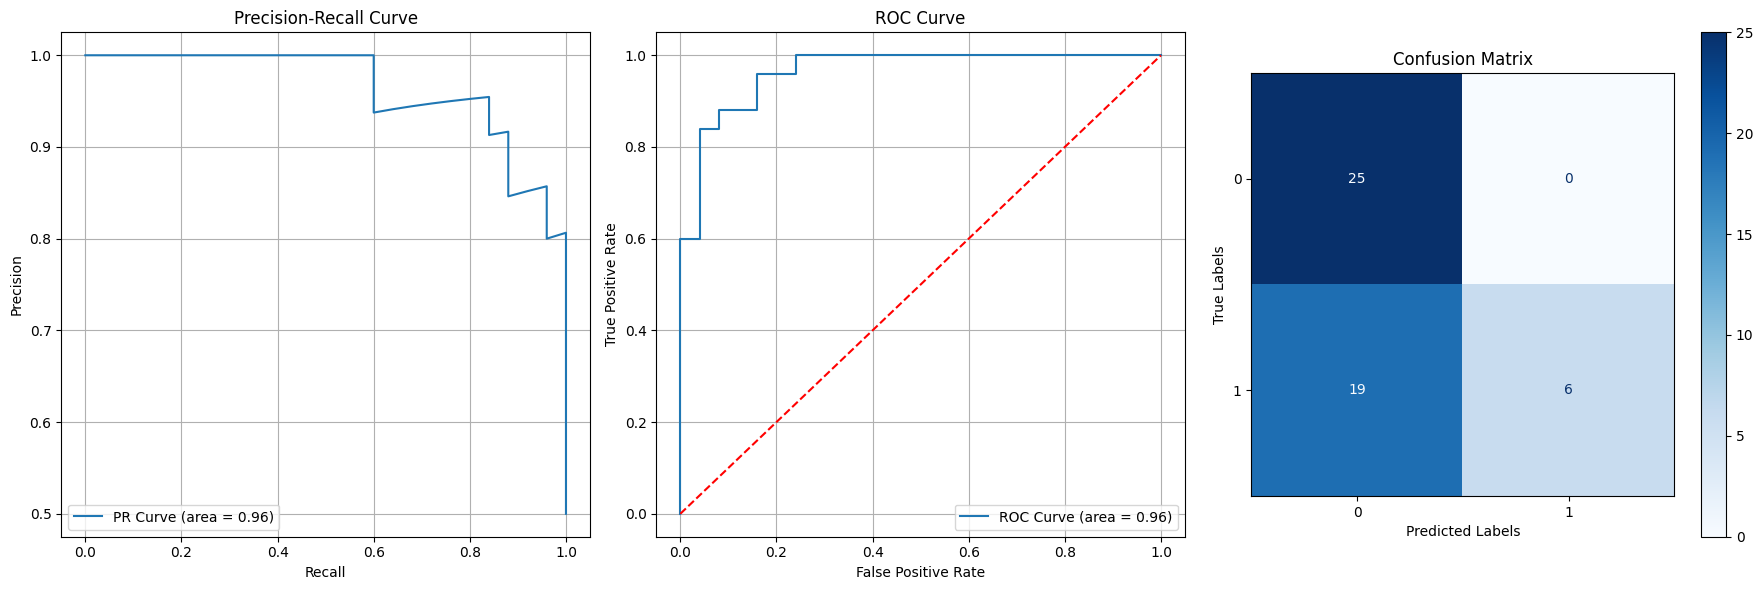

In [68]:
predicted_probs, predicted_labels, true_labels = model_utility.model_predict(deploy_loader, return_labels=True)
model_utility.model_test(true_labels, predicted_probs)